In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.model_selection import train_test_split

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [5]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [6]:
df = df[5::6] # Takes every sixth row
df.head(7)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
41,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8


In [7]:
df.index = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")#
df = df.drop(columns=["Date Time"])

<Axes: xlabel='Date Time'>

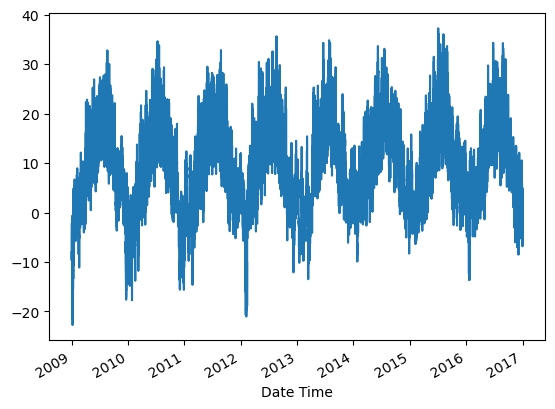

In [8]:
temp = df["T (degC)"]
temp.plot()

In [9]:
def extract_data(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = [] 

    for i in range(len(df_as_np) - window_size):
        row = [ [a] for a in df_as_np[i:i+window_size] ]
        X.append(row)
        y.append([df_as_np[i+window_size]])

    return np.array(X), np.array(y)

In [10]:
X, y = extract_data(temp, 5)

X.shape, y.shape

((70086, 5, 1), (70086, 1))

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
cp = ModelCheckpoint("model/", save_best_only=True)
def build_model():
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "linear"))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 
    
    return model


In [13]:
kf = KFold(n_splits=3, shuffle=False)

model = build_model()
for train_index, val_index in kf.split(X_train_val):

    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]
    #with tf.device('/GPU:0'):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp])

Epoch 1/5
1162/1169 [============================>.] - ETA: 0s - loss: 43.0611 - root_mean_squared_error: 6.5621

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 11s 7ms/step - loss: 42.8722 - root_mean_squared_error: 6.5477 - val_loss: 6.3353 - val_root_mean_squared_error: 2.5170
Epoch 2/5
1166/1169 [============================>.] - ETA: 0s - loss: 3.5301 - root_mean_squared_error: 1.8788

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 3.5270 - root_mean_squared_error: 1.8780 - val_loss: 2.1619 - val_root_mean_squared_error: 1.4704
Epoch 3/5
1155/1169 [============================>.] - ETA: 0s - loss: 1.5401 - root_mean_squared_error: 1.2410

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 1.5338 - root_mean_squared_error: 1.2385 - val_loss: 1.1695 - val_root_mean_squared_error: 1.0814
Epoch 4/5
1159/1169 [============================>.] - ETA: 0s - loss: 0.9908 - root_mean_squared_error: 0.9954

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 7s 6ms/step - loss: 0.9888 - root_mean_squared_error: 0.9944 - val_loss: 0.8622 - val_root_mean_squared_error: 0.9286
Epoch 5/5
1163/1169 [============================>.] - ETA: 0s - loss: 0.8071 - root_mean_squared_error: 0.8984

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 0.8071 - root_mean_squared_error: 0.8984 - val_loss: 0.7441 - val_root_mean_squared_error: 0.8626
Epoch 1/5
1159/1169 [============================>.] - ETA: 0s - loss: 0.7190 - root_mean_squared_error: 0.8479

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 0.7185 - root_mean_squared_error: 0.8476 - val_loss: 0.7089 - val_root_mean_squared_error: 0.8420
Epoch 2/5
1161/1169 [============================>.] - ETA: 0s - loss: 0.6808 - root_mean_squared_error: 0.8251

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 0.6804 - root_mean_squared_error: 0.8248 - val_loss: 0.6825 - val_root_mean_squared_error: 0.8262
Epoch 3/5
1159/1169 [============================>.] - ETA: 0s - loss: 0.6647 - root_mean_squared_error: 0.8153

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 0.6640 - root_mean_squared_error: 0.8149 - val_loss: 0.6724 - val_root_mean_squared_error: 0.8200
Epoch 4/5
1158/1169 [============================>.] - ETA: 0s - loss: 0.6535 - root_mean_squared_error: 0.8084

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 0.6546 - root_mean_squared_error: 0.8091 - val_loss: 0.6675 - val_root_mean_squared_error: 0.8170
Epoch 5/5
1160/1169 [============================>.] - ETA: 0s - loss: 0.6479 - root_mean_squared_error: 0.8049

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 0.6498 - root_mean_squared_error: 0.8061 - val_loss: 0.6624 - val_root_mean_squared_error: 0.8139
Epoch 1/5
1164/1169 [============================>.] - ETA: 0s - loss: 0.6512 - root_mean_squared_error: 0.8070

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 0.6502 - root_mean_squared_error: 0.8064 - val_loss: 0.6461 - val_root_mean_squared_error: 0.8038
Epoch 2/5
1156/1169 [============================>.] - ETA: 0s - loss: 0.6482 - root_mean_squared_error: 0.8051

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 7ms/step - loss: 0.6471 - root_mean_squared_error: 0.8044 - val_loss: 0.6459 - val_root_mean_squared_error: 0.8037
Epoch 3/5
1158/1169 [============================>.] - ETA: 0s - loss: 0.6430 - root_mean_squared_error: 0.8019

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 0.6441 - root_mean_squared_error: 0.8026 - val_loss: 0.6427 - val_root_mean_squared_error: 0.8017
Epoch 4/5
1169/1169 [==============================] - 5s 5ms/step - loss: 0.6415 - root_mean_squared_error: 0.8010 - val_loss: 0.6441 - val_root_mean_squared_error: 0.8025
Epoch 5/5
1160/1169 [============================>.] - ETA: 0s - loss: 0.6407 - root_mean_squared_error: 0.8004

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1169/1169 [==============================] - 8s 6ms/step - loss: 0.6400 - root_mean_squared_error: 0.8000 - val_loss: 0.6344 - val_root_mean_squared_error: 0.7965


In [21]:
from tensorflow.keras.models import load_model
model = load_model("model/")

In [22]:
y_pred = model.predict(X_test)

439/439 [==============================] - 1s 2ms/step


In [23]:
results = pd.DataFrame(data={"prediction": y_pred.flatten(), "label": y_test.flatten()})
def calc_diff(row):
    return np.abs(row.prediction - row.label)
results["diff"] = results.apply(calc_diff, axis="columns")
results

,prediction,label,diff
0,8.893715,8.81,0.083715
1,3.040253,2.66,0.380253
2,12.997864,13.26,0.262136
3,2.921401,2.02,0.901401
4,21.404810,24.14,2.735190
...,...,...,...
14013,12.781561,12.59,0.191561
14014,1.250415,0.80,0.450415
14015,20.840061,20.45,0.390061
14016,-0.284861,0.74,1.024861


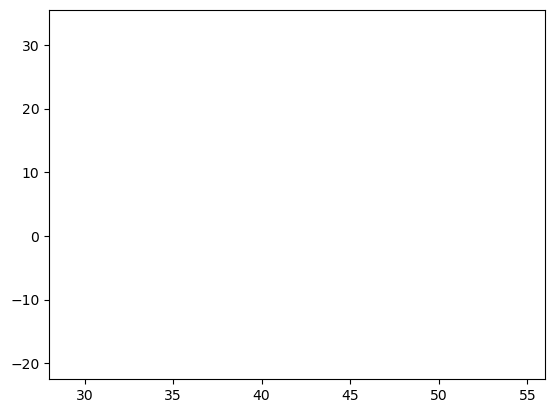

KeyboardInterrupt: 

In [24]:
from IPython.display import display, clear_output

day = 0
window_size = 28
rate = 4

plt.ion()
fig, ax = plt.subplots()
y_min = min(min(results["prediction"]), min(results["label"]))
y_max = max(max(results["prediction"]), max(results["label"]))

while day < 15000:
    ax.clear()

    ax.plot(np.arange(day, day + window_size), results["prediction"][day:day + window_size])
    ax.plot(np.arange(day, day + window_size), results["label"][day:day + window_size])
    ax.plot(np.arange(day, day + window_size), results["diff"][day:day + window_size])
    
    plt.xlim(day, day + window_size)
    plt.ylim(y_min, y_max)

    display(fig)
    clear_output(wait=True)

    day += rate
    plt.pause(0.1)

plt.show()

In [124]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
